In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import rasterio
import torch
import numpy as np

from functools import partial
from pathlib import Path
from rasterio.transform import Affine
from rasterio import windows

from dl_toolbox.callbacks.confusion_matrix import compute_conf_mat, plot_confusion_matrix
from dl_toolbox.utils import MergeLabels, LabelsToRGB, RGBToLabels
import dl_toolbox.datasets as datasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
if os.uname().nodename == 'WDTIS890Z': 
    data_root = Path('/mnt/d/pfournie/Documents/data')
    home = Path('/home/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename == 'qdtis056z': 
    data_root = Path('/data')
    home = Path('/d/pfournie')
    save_root = data_root / 'outputs'
else:
    #data_root = Path('/work/OT/ai4geo/DATA/DATASETS')
    data_root = Path(os.environ['TMPDIR'])
    home = Path('/home/eh/fournip')
    save_root = Path('/work/OT/ai4usr/fournip') / 'outputs'

save_dir = save_root / 'DIGITANIE'
log_name = 'toulouse'
version = '14Mar23-19h57m43'
pred_path = save_dir/log_name/version/'preds'

In [18]:
def dist_to_edge(i, j, h, w):

    mi = np.minimum(i+1, h-i)
    mj = np.minimum(j+1, w-j)
    return np.minimum(mi, mj)

In [19]:
# from https://github.com/rasterio/rasterio/blob/main/rasterio/merge.py
for d in os.scandir(pred_path):
    print(d)

<DirEntry 'Toulouse_EPSG32631_8'>
<DirEntry 'Toulouse_EPSG32631_9'>


In [23]:
d = pred_path/'Toulouse_EPSG32631_9'
xs = []
ys = []
for tif in os.scandir(d):
    with rasterio.open(tif) as src:
        left, bottom, right, top = src.bounds
        res = src.res # assume all res are the same
        profile = src.profile
        count = src.count
        dt = src.dtypes[0]
    xs.extend([left, right])
    ys.extend([bottom, top])
dst_w, dst_s, dst_e, dst_n = min(xs), min(ys), max(xs), max(ys)
output_width = int(round((dst_e - dst_w) / res[0]))
output_height = int(round((dst_n - dst_s) / res[1]))
output_transform = Affine.translation(dst_w, dst_n) * Affine.scale(res[0], -res[1])
out_profile = profile
out_profile["transform"] = output_transform
out_profile["height"] = output_height
out_profile["width"] = output_width
out_profile["count"] = count
out_profile["dtype"] = dt

probs = np.zeros((count, output_height, output_width), dtype=dt)
mask = np.zeros((output_height, output_width))

for tif in os.scandir(d):

    with rasterio.open(tif) as src:

        src_w, src_s, src_e, src_n = src.bounds
        height, width = src.shape
        dst_window = windows.from_bounds(src_w, src_s, src_e, src_n, output_transform)
        dst_window_rnd = dst_window.round_lengths().round_offsets()
        dst_h, dst_w = dst_window_rnd.height, dst_window_rnd.width
        dst_roff, dst_coff = dst_window_rnd.row_off, dst_window_rnd.col_off
        prob = src.read(out_dtype=dt)

    crop_mask = np.fromfunction(
        function=partial(
            dist_to_edge,
            h=height,
            w=width
        ),
        shape=(height, width),
        dtype=int
    )

    probs[:, dst_roff : dst_roff + dst_h, dst_coff : dst_coff + dst_w] += prob * crop_mask
    mask[dst_roff : dst_roff + dst_h, dst_coff : dst_coff + dst_w] += crop_mask

probs /= mask

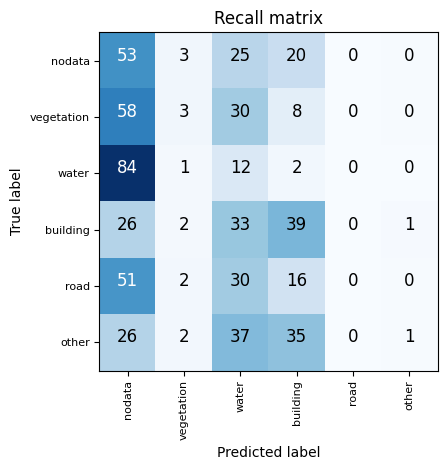

In [24]:
# datasets params
nomenc = 'mainFuseVege'
bands = [1,2,3]

dataset = datasets.Digitanie(
    image_path=data_root/'DIGITANIE'/'Toulouse'/'Toulouse_EPSG32631_9.tif',
    label_path=data_root/'DIGITANIE'/'Toulouse'/'COS9'/'Toulouse_9.tif'
)
merger = MergeLabels(dataset.nomenclatures[nomenc].value.merge)
class_names = [l.name for l in dataset.nomenclatures[nomenc].value.labels]
num_classes = len(class_names)

image = dataset.read_image(bands=bands)
label = dataset.read_label()
label = merger(np.squeeze(label))
label = torch.from_numpy(label).long()

conf, pred = torch.max(torch.from_numpy(probs), dim=0)

conf_mat = compute_conf_mat(
    label.flatten(),
    pred.flatten(),
    num_classes,
    ignore_idx=None
)

fig = plot_confusion_matrix(conf_mat, class_names, 'recall')